In [1]:
# Initialize to load modules
%load_ext autoreload
%autoreload 2

#For this project please set to False, since database and rag are already prepared.
#Enable SetupDBRag = True (This will allow to create new Database/Rag).
SetupDBRag = False
#To display the state at each step, default set to False unless need to debug
DebugLangGraph = False

In [2]:
# Initialize environment
import sys
import os
import importlib


# Add the parent directory to sys.path to resolve local imports
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # If in Colab, use the Google Drive path
    # Modify this path to point to the directory containing your 'controller' directory in Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    parent_dir = '/content/drive/MyDrive/Colab Notebooks/Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025/Week13/family_travel_planner' # <--- UPDATE THIS PATH
    print(f"Running in Google Colab. Using parent_dir: {parent_dir}")
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    !pip install -r '{parent_dir}/requirements.txt'
else:
    # If not in Colab, use the parent directory of the current working directory
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    print(f"Not running in Google Colab. Using parent_dir: {parent_dir}")
    #!python -m venv python310
    #!myenv\Scripts\python -m pip install ipykernel
    #!myenv\Scripts\python -m ipykernel install --user --name=python310 --display-name "Python (python 3.10.18 with requirements)"
    !python310\Scripts\python -m pip install -r C:\Users\thunaung\personal\education\AI\Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025\Week13\ai_prototype_project\requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Google Colab. Using parent_dir: /content/drive/MyDrive/Colab Notebooks/Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025/Week13/family_travel_planner


In [3]:
if SetupDBRag:
  #Create family_members database id,role,age,preferences
  !python scripts/create_database.py

  # Update contents to database: husband,wife,son,daughter &  preferences
  !python scripts/seed_data.py

In [4]:
#Upload travel brouchers in PDF format and URL format from TripAdviser to rag
if SetupDBRag:
  import sys
  import os
  from utils.rag_utils import ingest_documents

  def create_rag():
      sources = [
          {"type": "pdf", "path": '/content/drive/MyDrive/Colab Notebooks/Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025/Week13/family_travel_planner/travelguide/Americas_compressed.pdf'},
          {"type": "html", "url": "https://www.klook.com/en-SG/blog/cheapest-holidays-from-singapore/"}
      ]
      ingest_documents(sources, index_path="family_travel_rag.index")
      print("✅ RAG ingestion complete.")

  create_rag()

In [5]:
#If Running in colab then need to download the rag from virtual server to the google drive.
if SetupDBRag:
  import os

  # Define the source and destination paths
  source_path = "family_travel_rag.index"
  destination_dir = parent_dir # Copy to the project directory in Google Drive
  destination_path = os.path.join(destination_dir, source_path)
  # Check if the index file exists in the source location
  if os.path.exists(source_path):
      # Use shell command to copy the file
      !cp "{source_path}" "{destination_path}"
      print(f"Successfully copied {source_path} to {destination_path}")
  else:
      print(f"Error: {source_path} not found in the current directory.")

In [6]:
#Check if rag vectors (first 3 and last3 in vector format)
if SetupDBRag:
  import faiss
  import numpy as np
  import os
  import sys


  # Import the load_rag_index function from rag_utils
  try:
      from utils.rag_utils import load_rag_index
  except ImportError as e:
      print(f"Error importing load_rag_index: {e}")
      print(f"Current sys.path: {sys.path}")
      sys.exit(1)


  index_path = os.path.join(parent_dir, "family_travel_rag.index") # Use the path in Google Drive

  if os.path.exists(index_path):
      # Load the pickled FAISS index and documents
      try:
          index, docs = load_rag_index(index_path)
          print("✅ RAG index and documents loaded successfully.")

          # Get the total number of vectors in the index
          num_vectors = index.ntotal
          print(f"Total number of vectors in the index: {num_vectors}")

          if num_vectors > 0:
              # Get the first 3 vectors by internal index
              k_first = min(3, num_vectors)
              first_vectors_indices = list(range(k_first))
              try:
                  first_vectors = index.reconstruct_n(0, k_first)
                  print(f"\nFirst {k_first} vectors (by internal index):")
                  for i, vec in zip(first_vectors_indices, first_vectors):
                      print(f"Index {i}: {vec[:10]}...") # Print first 10 elements for brevity
              except Exception as e:
                  print(f"Could not retrieve first vectors by index: {e}")
                  print("Note: Not all FAISS index types support reconstruction.")


              # Get the last 3 vectors by internal index
              if num_vectors > 3:
                  k_last = 3
                  last_vectors_indices = list(range(max(0, num_vectors - k_last), num_vectors))
                  try:
                      last_vectors = index.reconstruct_n(max(0, num_vectors - k_last), k_last)
                      print(f"\nLast {k_last} vectors (by internal index):")
                      for i, vec in zip(last_vectors_indices, last_vectors):
                          print(f"Index {i}: {vec[:10]}...") # Print first 10 elements for brevity
                  except Exception as e:
                      print(f"Could not retrieve last vectors by index: {e}")
                      print("Note: Not all FAISS index types support reconstruction.")

              elif num_vectors > 0:
                  print("\nLess than 4 vectors in the index, cannot show last 3 unique vectors.")


          else:
              print("The index is empty.")

      except Exception as e:
          print(f"Error loading or processing index: {e}")


  else:
      print(f"Index file not found at: {index_path}")

In [7]:
# Assuming 'docs' and 'index' are already loaded from the previous step (cell 7de437df)
if SetupDBRag:
  if 'docs' in locals() and len(docs) > 0:
      print("Original text content for the first 3 vectors (by internal index):")
      k_first = min(3, len(docs))
      for i in range(k_first):
          print(f"\n--- Document for Index {i} ---")
          print(docs[i].page_content)

      if len(docs) > 3:
          print("\nOriginal text content for the last 3 vectors (by internal index):")
          k_last = 3
          for i in range(max(0, len(docs) - k_last), len(docs)):
              print(f"\n--- Document for Index {i} ---")
              print(docs[i].page_content)

      elif len(docs) > 0:
          print("\nLess than 4 documents available, cannot show last 3 unique documents.")

  else:
      print("Documents not loaded or the list is empty. Please run the cell to load the index and documents first.")

Test LangGraph

Running in Google Colab, retrieved secrets from userdata.
Building travel planner graph with LLM router...


/content/drive/MyDrive/Colab Notebooks/Emeritus_Generative_AI_Fundamentals_to_Advanced_Techniques_March_2025/Week13/family_travel_planner/agents/rag_agents.py:18: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedder = OpenAIEmbeddings()


Travel planner graph with LLM router built successfully.

--- Invoking routed graph with input: Plan a family trip to the beach  ---

--- Expecting TRAVEL_PLANNER ---
Fetch Family data from SQL: [{'id': 1, 'role': 'Husband', 'age': 42, 'preferences': {'museums': True, 'food': True}}, {'id': 2, 'role': 'Wife', 'age': 42, 'preferences': {'beach': True, 'shopping': True}}, {'id': 3, 'role': 'Son', 'age': 11, 'preferences': {'theme_parks': True, 'video_games': True}}, {'id': 4, 'role': 'Daughter', 'age': 10, 'preferences': {'animals': True, 'beach': True}}]
Common interest: beach
Things to do based on RAG: Based on the documents, a great family-friendly destination related to the beach is **Desaru, Malaysia**. Desaru is described as a laid-back coastal town perfect for a beach getaway. It offers a variety of activities suitable for families, including the Adventure Waterpark Desaru Coast, wildlife encounters, and ATV riding at the Desaru Fruit Farm. This makes it an excellent choice for fa

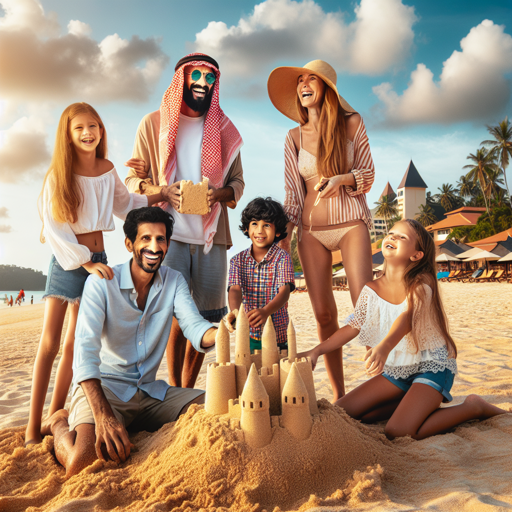


--- Invoking routed graph with input: How is the weather there? ---

--- Expecting WEATHER_INFO ---
Tool Output → Patchy rain nearby, 29.3°C


In [8]:
import re
import replicate
import numpy as np
from typing import Optional, List, Dict, Any, Literal
from pydantic import BaseModel,Field
from sentence_transformers import SentenceTransformer, util

from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_openai import OpenAIEmbeddings, ChatOpenAI # Import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate # Import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser # Import StrOutputParser
from openai import OpenAI # Import the openai library
import json # Import json

# Assuming these imports are necessary and the files exist in the mounted drive
from controller.controller import  load_state, merge_state, save_state, build_travel_planner_graph_with_router
from controller.shared_types import HybridState


# Test the travel planner graph with the LLM router
print("Building travel planner graph with LLM router...")
try:
    travel_planner_graph_routed = build_travel_planner_graph_with_router()
    print("Travel planner graph with LLM router built successfully.")

    # --- Test with different inputs ---

    # Test case 1: Trigger travel planner sequence
    print(f"\n--- Invoking routed graph with input: Plan a family trip to the beach  ---")
    print(f"\n--- Expecting TRAVEL_PLANNER ---")
    try:
        test_input_plan = "Plan a family trip to the beach"
        test_state_plan = HybridState(input=test_input_plan)
        raw = travel_planner_graph_routed.invoke(test_state_plan)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during TRAVEL_PLANNER invocation: {e}")


    # Test case 2: Trigger photo diea
    print(f"\n--- Invoking routed graph with input: Where can I take good photo there? ---")
    print(f"\n--- Expecting PHOTO_MEMORY ---")
    try:
        state = load_state()
        state = merge_state(state, "Where can I take good photo there?")
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during PHOTO_MEMORY invocation: {e}")

    # Test case 3: Weather
    print(f"\n--- Invoking routed graph with input: How is the weather there? ---")
    print(f"\n--- Expecting WEATHER_INFO ---")
    try:
        state = load_state()
        state = merge_state(state, "How is the weather there?")
        raw = travel_planner_graph_routed.invoke(state)
        state = HybridState(**raw)       # or compile(return_state=True) to skip this
        save_state(state)
    except Exception as e:
         print(f"\nAn error occurred during Weather invocation: {e}")


except NameError as e:
    print(f"\nError: {e}.")
except Exception as e:
    print(f"\nAn error occurred during graph building or invocation: {e}")

In [9]:
import gradio as gr
import json
from controller.controller import load_state, merge_state, save_state
from controller.shared_types import HybridState  # Assuming HybridState is in shared_types.py

# Assuming travel_planner_graph_routed is already built and available from a previous cell
# If not, you'll need to ensure the cell that builds it (like e09e742f) is run before this one.
# from cell e09e742f:
# travel_planner_graph_routed = build_travel_planner_graph_with_router()


def chat_interface(message, history):
    """
    Function to handle chat input and interact with the LangGraph.

    Args:
        message (str): The user's input message.
        history (list): The chat history (list of dictionaries with 'role' and 'content').

    Returns:
        list: The updated chat history in the new format.
    """
    # Gradio 4.x ChatInterface passes history as a list of dictionaries
    # Convert to the old list of lists format if your load_state/merge_state expects it,
    # or update load_state/merge_state to handle the new format directly.
    # For simplicity here, we'll work with the new format and build the response in it.

    # Initialize state for this turn
    current_state = HybridState(input=message)

    # If there's history, attempt to load the previous state
    if history:
        try:
            # Load the last saved state and merge the new input
            current_state = merge_state(loaded_state, message)
            loaded_state = load_state()

        except FileNotFoundError:
             # Handle case where state file doesn't exist (e.g., first message after a restart)
             print("No previous state found, starting fresh.")
             # current_state is already initialized with the new message
        except Exception as e:
             print(f"Error loading or merging state: {e}")
             # Decide how to handle state loading errors - maybe return an error message
             # For now, we'll proceed with the current_state initialized with the new message
             pass # Continue with the current_state


    # Invoke the LangGraph with the current state
    try:
        # Assuming travel_planner_graph_routed is globally available from a previous cell
        raw_output = travel_planner_graph_routed.invoke(current_state)
        # Update the state with the raw output from the graph
        updated_state = HybridState(**raw_output)

        # Save the updated state
        save_state(updated_state)

        # Extract the relevant output to display to the user
        bot_message_content = updated_state.output if updated_state.output else "Processed your request."

        # If there's a photo_url, append it to the message content
        if updated_state.photo_url:
            bot_message_content += f"\n\nGenerated Image URL: {updated_state.photo_url}"
            # Note: Gradio ChatInterface can display images if the content is a URL or path

        # Append the user message and bot response to the history in the new format
        # history is already passed in the new format by Gradio
        #history.append({"role": "user", "content": message})
        #history.append({"role": "assistant", "content": bot_message_content})
        history.append({ message})
        history.append({ bot_message_content})

    except NameError:
        bot_message_content = "Error: The travel planner graph is not built. Please run the cell to build the graph first."
        # history.append({"role": "user", "content": message})
        # history.append({"role": "assistant", "content": bot_message_content})
        history.append({ message})
        history.append({ bot_message_content})

    except Exception as e:
        print(f"Error during graph invocation: {e}")
        # history.append({"role": "user", "content": message})
        # history.append({"role": "assistant", "content": f"An error occurred while processing your request: {e}"})
        history.append({ message})
        history.append({ bot_message_content})
    return history

# Set up the Gradio ChatInterface
# Assuming the travel_planner_graph_routed object is available in the global scope
if 'travel_planner_graph_routed' in globals():
    print("Launching Gradio Chat Interface...")
    demo = gr.ChatInterface(
        fn=chat_interface,
        title="Family Travel Planner AI",
        description="Ask me to plan your family trip or get information about a destination!",
        # Gradio 4.x ChatInterface automatically handles role/content format for chatbot
        chatbot=gr.Chatbot(height=400), # Adjust chatbot height
        textbox=gr.Textbox(placeholder="Enter your travel query...", container=False, scale=7),
        # clear_btn and submit_btn are handled differently in newer versions
    )

    # Launch the Gradio interface
    demo.launch(share=True, debug=True) # share=True creates a public link
else:
    print("Travel planner graph not found. Please run the cell that builds 'travel_planner_graph_routed' before running this cell.")

Launching Gradio Chat Interface...


/tmp/ipython-input-9-3467999611.py:98: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(height=400), # Adjust chatbot height
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:322: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b944052dcce13c496b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b944052dcce13c496b.gradio.live
